# Some *stuff*

In [6]:
import torch
import os
import requests
import asyncio
import datasets
import chess
import aiohttp
from pprint import pprint
import numpy as np
import matplotlib.pyplot as plt
from copy import copy
from collections import Counter


host_name = os.environ['HOSTNAME'].replace(".pace.gatech.edu", '')
host_name = "atl1-1-01-006-29-0"
port = 8003
url = f"http://{host_name}:{port}/v1/chat/completions"
model_name = "Qwen/Qwen3-VL-8B-Instruct"
sampling_params = {
    "repetition_penalty": 1.0,
    # "presence_penalty": 2.0,
    "presence_penalty": 0.0,
    # "top_k": 40,
    "top_p": 1.0,
    "temperature": 1.0,
    "max_tokens": 32000,
}
json_example = {
    "model": model_name,
    "messages": [
        {"role": "system", "content": "You are a helpful assistant."},
        {"role": "user", "content": "Who won the world series in 2020?"}
    ],
    **sampling_params,
}

headers_example = {"Content-Type": "application/json"}

req = requests.post(url, json=json_example, headers=headers_example)
pprint(req.json())

{'choices': [{'finish_reason': 'stop',
              'index': 0,
              'logprobs': None,
              'message': {'annotations': None,
                          'audio': None,
                          'content': 'The **Los Angeles Dodgers** won the '
                                     '**2020 World Series**. They defeated the '
                                     '**Toronto Blue Jays** in **Game 6** with '
                                     'a score of **3-2**, securing their '
                                     '**fifth World Series title** in '
                                     'franchise history.\n'
                                     '\n'
                                     'This was the first World Series since '
                                     '1997 to be shortened due to the '
                                     '**COVID-19 pandemic**, with the series '
                                     'played in a **bubbling environment at '
                     

In [7]:

def qwen_complete(messages, max_completion_tokens=None):
    json_req = {
        "model": model_name,
        "messages": messages,
        "max_completion_tokens": max_completion_tokens,
        **sampling_params,
    }
    return requests.post(url, json=json_req, headers=headers_example).json()


async def async_qwen_complete(messages, max_completion_tokens=None):
    json_req = {
        "model": model_name,
        "messages": messages,
        "max_completion_tokens": max_completion_tokens,
        **sampling_params,
    }
    async with aiohttp.ClientSession(timeout=aiohttp.ClientTimeout(500000)) as session:
        async with session.post(url, json=json_req, headers=headers_example) as req:
            return await req.json()

async def func():
    async with aiohttp.ClientSession() as session:
        async with session.post(url, json=json_example, headers=headers_example) as req:
            return await req.json()
# await asyncio.gather(*[func() for _ in range(30)])

In [8]:
# what do I want? I want to evaluate qwen 3 vl 8b instruct 
# on the first move accuracy of the chess puzzle dataset. 
# kind of recreating the result to get a feel for the problems 
# and handling the data. Prep for the VeRL implementation.

In [9]:
dset = datasets.load_dataset("Lichess/chess-puzzles", split="train")
dset

README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00003.parquet:   0%|          | 0.00/165M [00:00<?, ?B/s]

data/train-00001-of-00003.parquet:   0%|          | 0.00/165M [00:00<?, ?B/s]

data/train-00002-of-00003.parquet:   0%|          | 0.00/165M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/5423662 [00:00<?, ? examples/s]

Dataset({
    features: ['PuzzleId', 'FEN', 'Moves', 'Rating', 'RatingDeviation', 'Popularity', 'NbPlays', 'Themes', 'OpeningTags', 'PuzzleUrl', 'GameUrl'],
    num_rows: 5423662
})

In [10]:
import chess
example = dset[0]
# chess.Board(example["FEN"]).turn == chess.BLACK
chess_format = "san"
if chess_format == "uci":
    system_prompt = """You are a precise chess engine. Given a FEN, output only the single best move in UCI notation after thinking (e.g. <thinking>...</thinking>\n<answer>e2e4</answer>)."""
else:
    system_prompt = """You are a precise chess engine. Given a FEN, output only the single best move in Standard Algebraic Notation (SAN) after thinking (e.g. <thinking>...</thinking>\n<answer>Nf3</answer>)"""
def get_chess_messages(fen):
    board = chess.Board(fen)
    user_content = fen # think about adding legal moves to the fen as well. list(board.generate_legal_moves())
    user_content += "\nHere are the legal moves for this fen:\n" + ", ".join(board.san(m) if chess_format == 'san' else board.uci(m) for m in board.generate_legal_moves())
    
    messages = [{'role': 'system', 'content': system_prompt},
                {'role': 'user', 'content': user_content}]
    return messages


# be flexible with the notation we accept for RL reasons.
# -- testing just using SAN instead of UCI. Could be the default instead, then I don't have to support both?
#    the result was that SAN resulted in more diversity, but there are still a bunch of UCI outputs
# -- its extremely easy, the chess library provides parsing for uci and san. Cake.


# try to get to a reasonable point for doing RL. 
# -- With extremely long sequences is it even going to be possible?
#    like what is the limit that I shouldn't really consider doing?
#    I guess I should approximate my computation at 6 - 12% mfu, which is what I seem to get from VeRL. I can't recall quite.
#    0.008 Trillion params * 2 FLOPS/(token*param) * SEQ_LEN tokens / problem * 32 problems / step * 200 steps / 0.06 (efficiency) -> 1710 tflops per token
#    we desire something that is less than 4 hrs on an h200, which has ~1000 tflops -> 1000 tflops * 4 * 3600 = 14,400,000 tflops
#    SEQ_LEN = tflops available / tflops needed per token -> 8k sequence lengths...?? this feels wrong? 
#    its possible for chess I've severly underestimated the number of examples needed.
#    will use it as a rough limit idea tho. 4k doable probably.
# -- Need good baseline starting accuracy. Aiming for 10% in the language only domain.
#    got 0.6% right now, very bad. too bad in fact I think.
#    10% achievable with including the valid moves incontext, so now will set up text based RL pipeline. 
#    going to view the performance without any of the sampling parameters first? (don't really need to do this, but will. Does like good enought pretty close.)

messages = get_chess_messages(example['FEN'])

example = dset[7]
pprint(example)
board = chess.Board(example['FEN'])
# board.parse_uci('e5f6').uci() # InvalidMoveError or IllegalMoveError raised on error.
# board.parse_san("e4") # raises IllegalMoveError if illegal move.
# uci_move = chess.Board(example['FEN']).parse_san('b5')
# res = qwen_complete(messages, 800)
# pprint(res)

{'FEN': '4r3/1k6/pp3r2/1b2P2p/3R1p2/P1R2P2/1P4PP/6K1 w - - 0 35',
 'GameUrl': 'https://lichess.org/n8Ff742v#69',
 'Moves': 'e5f6 e8e1 g1f2 e1f1',
 'NbPlays': 637,
 'OpeningTags': None,
 'Popularity': 86,
 'PuzzleId': '000Zo',
 'PuzzleUrl': 'https://lichess.org/training/000Zo',
 'Rating': 1353,
 'RatingDeviation': 75,
 'Themes': ['endgame', 'mate', 'mateIn2', 'short']}


In [11]:
# assistant_answer_prompt = res['choices'][0]['message']['content'] + "\n\nConsidering the limited time by the user, I have to give the\nsolution based on the thinking directly now.\n</thinking>"
# assistant_answer_prompt
# messages = [{'role': 'system', 'content': system_prompt},
#             {'role': 'user', 'content': example["FEN"]},
#             {'role': 'assistant', 'content': assistant_answer_prompt}]
# qwen_complete(messages, 800)

In [12]:
async def async_ensured_qwen_completion(fen, max_completion_tokens=800):
    messages = get_chess_messages(fen)
    res = await async_qwen_complete(messages, max_completion_tokens)
    if res['choices'][0]['finish_reason'] == "length":
        assistant_partial = res['choices'][0]['message']['content'] + "\n\nConsidering the limited time by the user, I have to give the\nsolution based on the thinking directly now.\n</thinking>"
        messages = messages + [{'role': 'assistant', 'content': assistant_partial}]
        res_2 = await async_qwen_complete(messages, 800)
        res['choices'][0]['message']['content'] = assistant_partial + res_2['choices'][0]['message']['content']
    return res

In [13]:
# takes 4 minutes to execute this cell on h200.
seed_value = 42
rng = np.random.default_rng(seed_value)
n_examples = 100
indices = rng.choice(len(dset), n_examples)
n_rollouts = 10

# dset[indices]
# look at 100 example puzzles trying each 10 times to see distribution from qwen 3 vl 8b instruct.
jobs = []
train_examples = []
for i in indices:
    fen = dset[i]['FEN']
    for _ in range(n_rollouts):
        train_examples.append(copy(dset[i])) # would like to do something like train_examples[-1] = await job. I'll just do it afterwards for now.
        messages = get_chess_messages(fen)
        jobs.append(async_qwen_complete(messages, 10000))
res = await asyncio.gather(*jobs)
text_res = [r['choices'][0]['message']['content'] for r in res]

In [14]:
for train_example, res_json in zip(train_examples, res):

    board = chess.Board(train_example['FEN'])
    r = res_json['choices'][0]['message']['content']
    train_example['response_json'] = res_json
    train_example["response"] = r
    train_example["is_valid_move"] = False
    train_example["is_correct_move"] = False

    try:
        ans = r.split('<answer>')[1].split("</answer>")[0]
        train_example["prediction"] = ans
    except:
        train_example["exception"] = "missing_answer_tags"
        train_example["prediction"] = None
        continue

    fail = False
    try:
        move = board.parse_uci(ans) # I don't think that uci and sans have any intersection.
        train_example['parse_format'] = 'uci'
    except (chess.IllegalMoveError, chess.InvalidMoveError) as e:
        try:
            move = board.parse_san(ans)
            train_example['parse_format'] = 'san'

        except (chess.IllegalMoveError, chess.InvalidMoveError, chess.AmbiguousMoveError) as e:
            fail = True 
            train_example["exception"] = e.__class__
            continue
    # in the case that both fail, I don't want to increment correct moves, but in the case that at least one of them succeeds, I'd like to increment.
    if not fail:
        train_example["is_valid_move"] = True
        train_example["is_correct_move"] = (move == board.parse_uci(train_example['Moves'].split(" ")[0]))


In [15]:
# uci
# 800 -> 6 unique correct
# 4000 -> 10 unique correct with 13 correct overall.
# 8000 -> 9 unique correct with 12 correct overall. 4 min 11 sec
# 16000 -> 15 unique correct with 20 correct overall 4 min 36sec???
# 30000 -> 6 unique and 7 overall (of the 7, 4 were in uci rest were san. 108/1000 parseable) 4 min 7 sec??? (max len was 8490, so checks out actually.)

# asking for san
# 10000 -> 8 and 10 Counter({'san': 134, 'uci': 2}) of correctly parsed answers.

# asking for san, and putting the legal moves in the context:
# 10000 -> 34 and 117!!!
# I think we should document the number of incorrect as well...
# maybe even save the data? for longer runs especially important.

In [22]:
import pandas as pd

df = pd.DataFrame.from_records(train_examples)

# sum([sum(train_example['is_correct_move'] for train_example in train_rollout_group) for train_rollout_group in np.array_split(train_examples, n_examples)])
(df.groupby('PuzzleId').agg({"is_correct_move": "sum"}).is_correct_move).sum()

104

In [17]:
Counter(df.exception.values)
# Counter({chess.IllegalMoveError: 792,
#          nan: 108,
#          chess.InvalidMoveError: 97,
#          'missing_answer_tags': 2,
#          chess.AmbiguousMoveError: 1})
# Counter({chess.IllegalMoveError: 768,
#          nan: 120,
#          chess.InvalidMoveError: 103,
#          'missing_answer_tags': 5,
#          chess.AmbiguousMoveError: 4})
# Counter({nan: 964, # this includes sampling parameters
#          chess.IllegalMoveError: 31,
#          'missing_answer_tags': 3,
#          chess.InvalidMoveError: 2})
# Counter({nan: 879, # this removes sampling parameters
#          'missing_answer_tags': 65,
#          chess.IllegalMoveError: 54,
#          chess.AmbiguousMoveError: 2})

Counter({nan: 910,
         'missing_answer_tags': 48,
         chess.IllegalMoveError: 40,
         chess.AmbiguousMoveError: 2})

In [18]:
Counter(df[df.exception.isna()].parse_format)

Counter({'san': 910})

In [19]:
df.groupby('PuzzleId').apply(lambda x: len(set(x["prediction"]) - {None}), include_groups=False).values

array([7, 4, 5, 6, 4, 5, 6, 7, 7, 2, 7, 7, 6, 4, 8, 5, 6, 5, 4, 4, 7, 3,
       2, 4, 4, 5, 3, 4, 5, 9, 8, 6, 5, 6, 7, 3, 5, 3, 6, 4, 4, 8, 6, 3,
       6, 7, 6, 3, 8, 2, 7, 7, 5, 2, 6, 7, 6, 2, 5, 6, 3, 4, 6, 5, 5, 3,
       8, 7, 8, 7, 5, 5, 2, 5, 6, 6, 5, 2, 6, 4, 5, 4, 1, 4, 5, 5, 6, 5,
       6, 3, 7, 4, 1, 3, 4, 3, 3, 8, 2, 6])

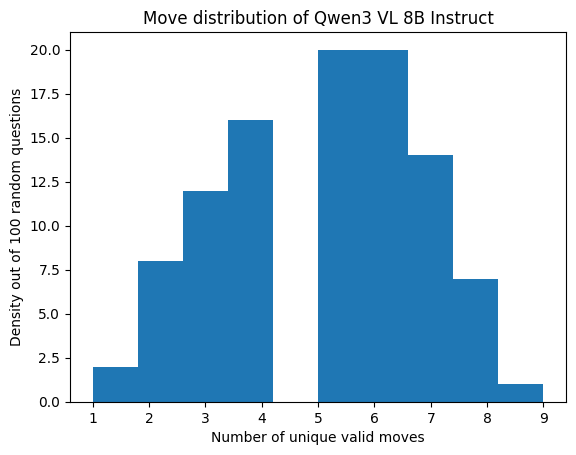

In [20]:
plt.hist(df.groupby('PuzzleId').apply(lambda x: len(set(x["prediction"]) - {None}), include_groups=False).values)
plt.title("Move distribution of Qwen3 VL 8B Instruct")
plt.ylabel("Density out of 100 random questions")
plt.xlabel("Number of unique valid moves")
plt.show()

In [21]:
[(set([r.split('<answer>')[1].split("</answer>")[0] for r in res[i*10: (i+1)*10]])) for i in range(100)]

AttributeError: 'dict' object has no attribute 'split'

In [ ]:
from transformers import AutoTokenizer
model_name = "Qwen/Qwen3-VL-8B-Instruct"
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.tokenize("<thinking>Position analysis: Black to move. White has a queen and rook on the queenside<think></think>")

In [ ]:
o = tokenizer(text_res)

In [ ]:
max(len(i) for i in o.input_ids)

In [ ]:
plt.hist([len(l) for l, t in zip(o.input_ids, train_examples)])

plt.hist([len(l) for l, t in zip(o.input_ids, train_examples) if t['is_correct_move']]) # amplified by 10 for now because 0.6% acc is too low.

In [ ]:
pprint(tokenizer.chat_template)

In [ ]:
messages

In [ ]:
example